In [1]:
# Basic Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import time
import matplotlib as mp
from sklearn.metrics import roc_curve, auc, precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier, BallTree, KDTree 
sns.set() # set the default Seaborn style for graphics

In [2]:
cardio_clean = pd.read_csv('cardio_updated.csv')
cardio_clean.head()
   
# replace the ‘commissioned' column contains
# the values 'yes' and 'no'  with 
# True and  False:
cardio_clean['Diagnosis'] = cardio_clean['Diagnosis'].map(
                   {'Yes': 1 ,'No': 0})
# show the dataframe
cardio_clean.head()

,Age,Gender,Height,Weight,Systolic Blood Pressure,Diastolic Blood Pressure,Cholesterol,Glucose,Smoking,Alcohol Intake,Physical Activity,Diagnosis,BMI
0,50,Male,168,62,110,80,Normal,Normal,No,No,Yes,0,22.0
1,55,Female,156,85,140,90,Extremely High,Normal,No,No,Yes,1,34.9
2,52,Female,165,64,130,70,Extremely High,Normal,No,No,No,1,23.5
3,48,Male,169,82,150,100,Normal,Normal,No,No,Yes,1,28.7
4,48,Female,156,56,100,60,Normal,Normal,No,No,No,0,23.0


In [3]:
cardio_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68675 entries, 0 to 68674
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       68675 non-null  int64  
 1   Gender                    68675 non-null  object 
 2   Height                    68675 non-null  int64  
 3   Weight                    68675 non-null  int64  
 4   Systolic Blood Pressure   68675 non-null  int64  
 5   Diastolic Blood Pressure  68675 non-null  int64  
 6   Cholesterol               68675 non-null  object 
 7   Glucose                   68675 non-null  object 
 8   Smoking                   68675 non-null  object 
 9   Alcohol Intake            68675 non-null  object 
 10  Physical Activity         68675 non-null  object 
 11  Diagnosis                 68675 non-null  int64  
 12  BMI                       68675 non-null  float64
dtypes: float64(1), int64(6), object(6)
memory usage: 6.8+ MB


# LOGISTIC REGRESSION

## Using Numerical columns only:

In [4]:
def Classifier(X_train, X_test, y_train, y_test):

  # Linear Regression using Train Data
  logreg = LogisticRegression()      
  logreg.fit(X_train, y_train.values.ravel())

  # Coefficients of the Linear Regression line
  print('Intercept of Regression \t: b = ', logreg.intercept_)
  print('Coefficients of Regression \t: a = ', logreg.coef_)
  print()

  # Print the Coefficients against Predictors
  print(pd.DataFrame(list(zip(X_train.columns, logreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
  print()

  # Predict Response corresponding to Predictors
  y_train_pred = logreg.predict(X_train)
  y_test_pred = logreg.predict(X_test)

  y_train_prob = logreg.predict_proba(X_train)
  y_test_prob = logreg.predict_proba(X_test)

  fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
  fpr_val, tpr_val, thresholds = metrics.roc_curve(y_test, y_test_prob[:,1], pos_label = 1)

  model_metrics = pd.DataFrame({'train' : {'accuracy'  : metrics.accuracy_score(y_train, y_train_pred),
                                          'precision' : metrics.precision_score(y_train, y_train_pred),
                                          'recall'    : metrics.recall_score(y_train, y_train_pred),
                                          'f1'        : metrics.f1_score(y_train, y_train_pred),
                                          'auc'       : metrics.auc(fpr_train, tpr_train)},
                        
                                'val'  : {'accuracy'  : metrics.accuracy_score(y_test, y_test_pred),
                                          'precision' : metrics.precision_score(y_test, y_test_pred),
                                          'recall'    : metrics.recall_score(y_test, y_test_pred),
                                          'f1'        : metrics.f1_score(y_test, y_test_pred),
                                          'auc'       : metrics.auc(fpr_val, tpr_val)}
                              })

  return model_metrics

In [5]:
# Extract Response and Predictors
y = pd.DataFrame(cardio_clean["Diagnosis"])
X = pd.DataFrame(cardio_clean[['Age', 'Height', 'Weight', 'BMI', 'Systolic Blood Pressure', 'Diastolic Blood Pressure']])

In [6]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
Classifier(X_train, X_test, y_train, y_test)

Intercept of Regression 	: b =  [-9.67121301]
Coefficients of Regression 	: a =  [[ 0.05477376 -0.01520994  0.01911223 -0.01628058  0.05677576  0.01357783]]

                 Predictors  Coefficients
0                       Age      0.054774
1                    Height     -0.015210
2                    Weight      0.019112
3                       BMI     -0.016281
4   Systolic Blood Pressure      0.056776
5  Diastolic Blood Pressure      0.013578



,train,val
accuracy,0.719314,0.722174
precision,0.743458,0.748965
recall,0.659661,0.659762
f1,0.699057,0.701539
auc,0.779877,0.783331


## Using Categorical and Numerical columns: 

In [7]:
cardio_new = pd.read_csv('cardio_updated.csv')
cardio_new.head()

cardio_new['Gender'] = cardio_new['Gender'].map(
                    {'Female': 1 ,'Male': 0})

cardio_new['Cholesterol'] = cardio_new['Cholesterol'].map(
                   {'Extremely High': 1 , 'High': 0.5, 'Normal': 0})

cardio_new['Glucose'] = cardio_new['Glucose'].map(
                   {'Extremely High': 1 , 'High': 0.5, 'Normal': 0})

cardio_new['Smoking'] = cardio_new['Smoking'].map(
                   {'Yes': 1 ,'No': 0})

cardio_new['Alcohol Intake'] = cardio_new['Alcohol Intake'].map(
                   {'Yes': 1 ,'No': 0})

cardio_new['Physical Activity'] = cardio_new['Physical Activity'].map(
                   {'Yes': 1, 'No': 0})

cardio_new['Diagnosis'] = cardio_new['Diagnosis'].map(
                   {'Yes': 1, 'No': 0})

cardio_new.head()

,Age,Gender,Height,Weight,Systolic Blood Pressure,Diastolic Blood Pressure,Cholesterol,Glucose,Smoking,Alcohol Intake,Physical Activity,Diagnosis,BMI
0,50,0,168,62,110,80,0.0,0.0,0,0,1,0,22.0
1,55,1,156,85,140,90,1.0,0.0,0,0,1,1,34.9
2,52,1,165,64,130,70,1.0,0.0,0,0,0,1,23.5
3,48,0,169,82,150,100,0.0,0.0,0,0,1,1,28.7
4,48,1,156,56,100,60,0.0,0.0,0,0,0,0,23.0


In [8]:
# Extract Response and Predictors
y = pd.DataFrame(cardio_new["Diagnosis"])
X = pd.DataFrame(cardio_new.drop(columns = ['Diagnosis']))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Classifier(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Intercept of Regression 	: b =  [-0.05440434]
Coefficients of Regression 	: a =  [[ 0.04748639 -0.12257067 -0.06733716  0.06734742  0.05440668  0.01077638
   0.91862468 -0.11138909 -0.14564567 -0.19288693 -0.18121483 -0.14740962]]

                  Predictors  Coefficients
0                        Age      0.047486
1                     Gender     -0.122571
2                     Height     -0.067337
3                     Weight      0.067347
4    Systolic Blood Pressure      0.054407
5   Diastolic Blood Pressure      0.010776
6                Cholesterol      0.918625
7                    Glucose     -0.111389
8                    Smoking     -0.145646
9             Alcohol Intake     -0.192887
10         Physical Activity     -0.181215
11                       BMI     -0.147410



,train,val
accuracy,0.725119,0.727649
precision,0.750244,0.757029
recall,0.665239,0.662234
f1,0.705189,0.706466
auc,0.787690,0.792958


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


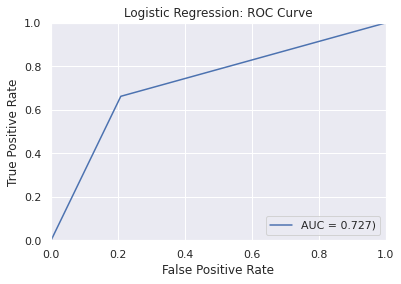

In [9]:
logreg = LogisticRegression()      
logreg.fit(X_train, y_train.values.ravel())
y_test_pred = logreg.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression: ROC Curve')
plt.legend(loc="lower right");

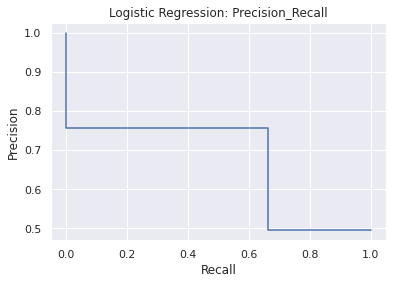

In [10]:
prec, rec, thresholds_2 = precision_recall_curve(y_test, y_test_pred)
r = PrecisionRecallDisplay(precision=prec, recall=rec)
r.plot()
plt.title("Logistic Regression: Precision_Recall")
plt.show()

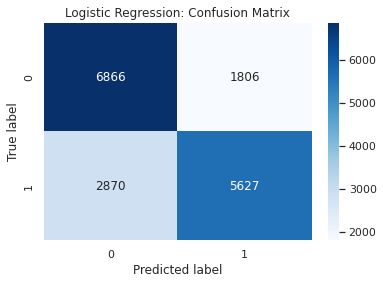

In [11]:
conf = confusion_matrix(y_test, y_test_pred)
h=sns.heatmap(conf,annot=True,cmap='Blues', fmt='g')
h.set_title("Logistic Regression: Confusion Matrix");
h.set_ylabel("True label");
h.set_xlabel("Predicted label");

# K Nearest Neighbours

We randomly choose 5 neighbours to classify. 

In [12]:
# KNN using Train Data
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

# Predict Response corresponding to Predictors
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print('Train Classification report:\n',classification_report(y_train,y_train_pred))

# Check the Goodness of Fit (on Test Data)
print('Test Classification report:\n',classification_report(y_test,y_test_pred))

# # Plot the Confusion Matrix for Train and Test
# f, axes = plt.subplots(1, 2, figsize=(20, 8))
# sb.heatmap(confusion_matrix(y_train, y_train_pred),
#            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
# sb.heatmap(confusion_matrix(y_test, y_test_pred), 
#            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train Classification report:
               precision    recall  f1-score   support

           0       0.77      0.80      0.78     26052
           1       0.78      0.75      0.77     25454

    accuracy                           0.77     51506
   macro avg       0.78      0.77      0.77     51506
weighted avg       0.77      0.77      0.77     51506

Test Classification report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      8672
           1       0.69      0.66      0.68      8497

    accuracy                           0.69     17169
   macro avg       0.69      0.69      0.69     17169
weighted avg       0.69      0.69      0.69     17169



In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
y_test

,Diagnosis
47346,0
3491,1
17219,0
26029,0
23290,0
...,...
17485,0
62763,0
66428,1
1479,1


In [14]:
#hyperparameter optimization for k values
error = []

for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i.reshape(len(pred_i), 1) != y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

Text(0, 0.5, 'Mean Error')

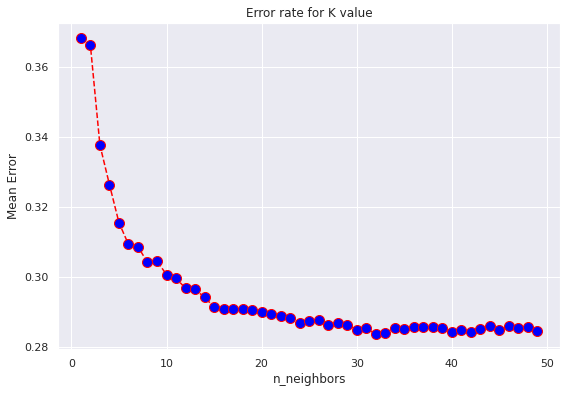

In [15]:
plt.figure(figsize = (9,6))
plt.plot((range(1,50)), error, color = 'red', linestyle = 'dashed', marker = 'o', markerfacecolor = 'blue', markersize = 10)
plt.title('Error rate for K value')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Error')

In [20]:
# KNN using Train Data
knnn = KNeighborsClassifier(n_neighbors = 40, weights = 'uniform', algorithm = 'ball_tree', p = 1, leaf_size = 10)
knnn.fit(X_train, y_train)

# Predict Response corresponding to Predictors
y_train_pred = knnn.predict(X_train)
y_test_pred = knnn.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print('Train Classification report:\n',classification_report(y_train,y_train_pred))

# Check the Goodness of Fit (on Test Data)
print('Test Classification report:\n',classification_report(y_test,y_test_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train Classification report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75     20749
           1       0.77      0.66      0.71     20455

    accuracy                           0.73     41204
   macro avg       0.74      0.73      0.73     41204
weighted avg       0.74      0.73      0.73     41204

Test Classification report:
               precision    recall  f1-score   support

           0       0.71      0.78      0.74      5303
           1       0.74      0.66      0.69      4999

    accuracy                           0.72     10302
   macro avg       0.72      0.72      0.72     10302
weighted avg       0.72      0.72      0.72     10302



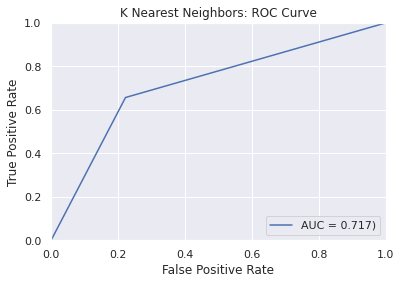

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K Nearest Neighbors: ROC Curve')
plt.legend(loc="lower right");

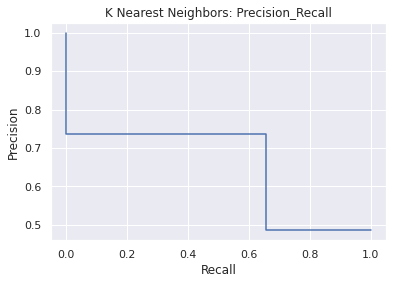

In [25]:
prec, rec, thresholds_2 = precision_recall_curve(y_test, y_test_pred)
r = PrecisionRecallDisplay(precision=prec, recall=rec)
r.plot()
plt.title("K Nearest Neighbors: Precision_Recall")
plt.show()

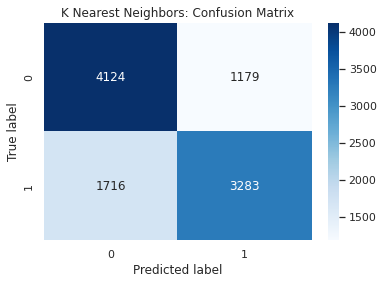

In [26]:
conf = confusion_matrix(y_test, y_test_pred)
h=sns.heatmap(conf,annot=True,cmap='Blues', fmt='g')
h.set_title("K Nearest Neighbors: Confusion Matrix");
h.set_ylabel("True label");
h.set_xlabel("Predicted label");